In [2]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from tqdm.auto import tqdm

from sparsenn.ad import filter_value_and_grad
from sparsenn.linear import ResMLP
from sparsenn.opt import apply_updates, flatten
from sparsenn.utils import nparams

In [3]:
# create a sparse MLP with skip connections
# this has in the middle 10 residual linear blocks
# where each block has 2 64x64 sparse linear layers
rng = jax.random.PRNGKey(0)
mlp = ResMLP(
    rng,
    in_dims=1,
    out_dims=1,
    hidden_dims=64,
    n_blocks=10,
    sparsity=0.95,
    dense_rows=1,
    dense_cols=1,
)
nparams(mlp)

7975

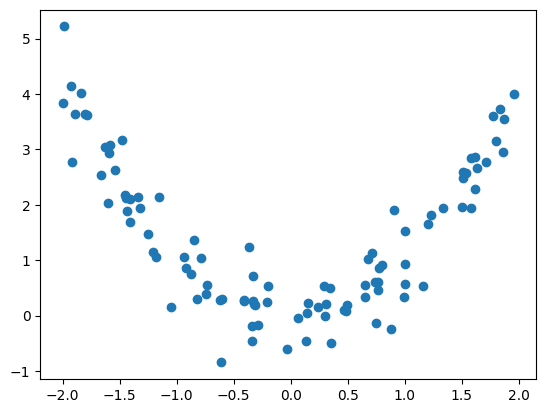

In [4]:
# create a dummy regression dataset y = x^2 + e
np.random.seed(1)
x = jnp.asarray(np.random.uniform(-2, 2, size=100)).reshape(-1, 1)
y = jnp.asarray(np.random.normal(x**2, 0.5))
plt.scatter(x, y)

In [5]:
# sparsenn works with optax transformations via the `flatten` wrapper
optimizer = flatten(optax.adamw(1e-3))
opt_state = optimizer.init(mlp)

In [6]:
# mse loss function
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jnp.mean((pred_y - y) ** 2)

In [7]:
# standard optax update loop. use the custom `sparsenn.apply_updates` function
@eqx.filter_jit
def step(model, opt_state, x, y):
    loss_value, grads = filter_value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = apply_updates(model, updates)
    return model, opt_state, loss_value

In [8]:
# train

losses = []

for i in (pbar := tqdm(range(1_000))):
    mlp, opt_state, loss_value = step(mlp, opt_state, x, y)
    losses.append(loss_value)
    pbar.set_description(f"loss: {loss_value:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

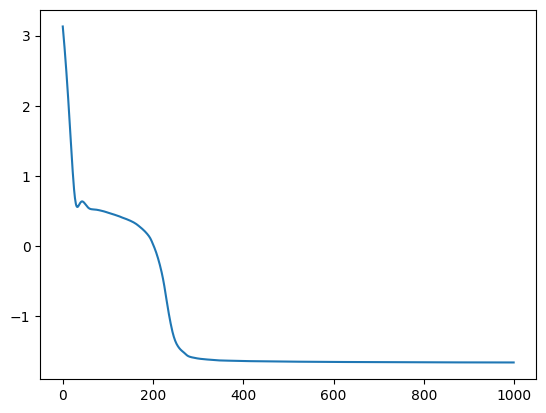

In [9]:
plt.plot(np.log(losses))

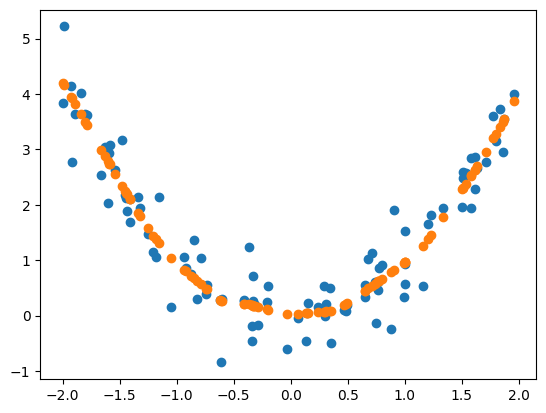

In [10]:
plt.scatter(x, y)
plt.scatter(x, jax.vmap(mlp)(x))